INFO:__main__:Using device: cuda
INFO:__main__:Environment setup complete.
INFO:__main__:Loaded data: 1000 samples, class distribution: [250 250 250 250]
INFO:__main__:Test set size: 100, class distribution: [25 25 25 25]
INFO:__main__:Pool set size: 900, class distribution: [225 225 225 225]
INFO:__main__:Fold 1 train size: 600, class distribution: [150 150 150 150]
INFO:__main__:Fold 1 val size: 300, class distribution: [75 75 75 75]
INFO:__main__:Epoch 1/30 - Train Loss: 1.2881, Train Acc: 0.4350, Val Loss: 1.0035, Val Acc: 0.5833
INFO:__main__:Epoch 2/30 - Train Loss: 0.9395, Train Acc: 0.6200, Val Loss: 0.8760, Val Acc: 0.6400
INFO:__main__:Epoch 3/30 - Train Loss: 0.7589, Train Acc: 0.7300, Val Loss: 0.8569, Val Acc: 0.6800
INFO:__main__:Epoch 4/30 - Train Loss: 0.7065, Train Acc: 0.7350, Val Loss: 0.6815, Val Acc: 0.7900
INFO:__main__:Epoch 5/30 - Train Loss: 0.6814, Train Acc: 0.7567, Val Loss: 0.6781, Val Acc: 0.7733
INFO:__main__:Epoch 6/30 - Train Loss: 0.6186, Train Acc: 0.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\adwai/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [08:30<00:00, 1.09MB/s]  
INFO:__main__:Epoch 1/30 - Train Loss: 1.2332, Train Acc: 0.4733, Val Loss: 0.9543, Val Acc: 0.7000
INFO:__main__:Epoch 2/30 - Train Loss: 0.8685, Train Acc: 0.7033, Val Loss: 0.7649, Val Acc: 0.8000
INFO:__main__:Epoch 3/30 - Train Loss: 0.7504, Train Acc: 0.7900, Val Loss: 0.5613, Val Acc: 0.8833
INFO:__main__:Epoch 4/30 - Train Loss: 0.6400, Train Acc: 0.8467, Val Loss: 0.5295, Val Acc: 0.9233
INFO:__main__:Epoch 5/30 - Train Loss: 0.6078, Train Acc: 0.8433, Val Loss: 0.4705, Val Acc: 0.9333
INFO:__main__:Epoch 6/30 - Train Loss: 0.5482, Train Acc: 0.8817, Val Loss: 0.4251, Val Acc: 0.9467
INFO:__main__:Epoch 7/30 - Train Loss: 0.4713, Train Acc: 0.9317, Val Loss: 0.4008, Val Acc: 0.9667
INFO:__main__:Epoch 8/30 - Train Loss: 0.4660, Train Acc: 0.9217, Val Loss: 0.3503, Val Acc: 0.9700
INFO:__main__:Epoch 9/30 - Train Loss: 0.4523, Train Acc: 0.9283, Val Loss: 0.3116, Val Acc: 0.9800
INFO:__main__:Epoch 10/30 - Train Loss: 0.4292,

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        25
           2     1.0000    0.9600    0.9796        25
           3     0.9615    1.0000    0.9804        25
           4     1.0000    1.0000    1.0000        25

    accuracy                         0.9900       100
   macro avg     0.9904    0.9900    0.9900       100
weighted avg     0.9904    0.9900    0.9900       100



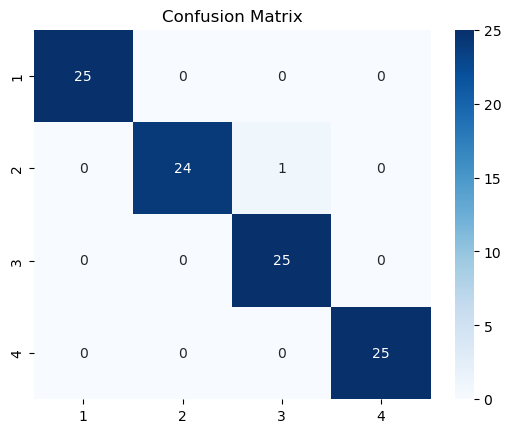

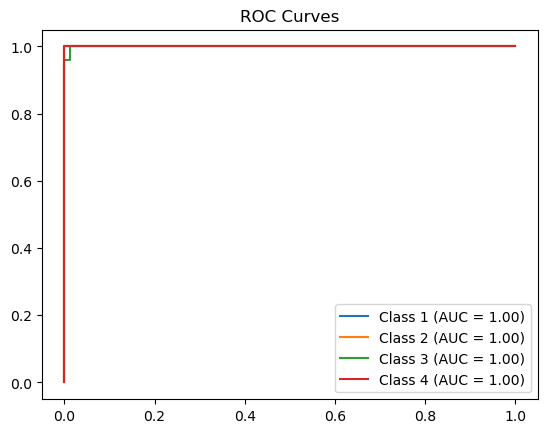

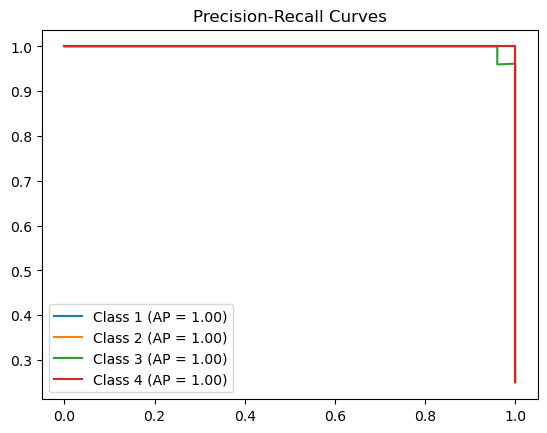

INFO:__main__:✅ Pipeline complete.


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import logging
from PIL import Image
import uuid

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class Config:
    DATA_PATH = "./augmented_data_output"
    MODEL_PATH = "./models/"
    RESULTS_PATH = "./results/"
    CLASSES = ["1", "2", "3", "4"]
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 8
    NUM_CLASSES = 4
    EPOCHS = 30
    RANDOM_SEED = 42
    N_SPLITS = 3
    TTA_STEPS = 5

    MODEL_CONFIGS = {
        'MobileNetV2': {
            'lr': 5e-5,
            'unfreeze_layers': -10,
            'dense_units': 128,
            'l2_lambda': 0.01,
            'dropout_rate': 0.5
        },
        'VGG16_v1': {
            'lr': 5e-5,
            'unfreeze_block': 'features.24',
            'dense_units': 32,
            'l2_lambda': 0.01,
            'dropout_rate': 0.5
        },
        'VGG16_v2': {
            'lr': 1e-4,
            'unfreeze_layers': ['features.26', 'features.28'],
            'dense_units': 24,
            'l2_lambda': 0.03,
            'dropout_rate': 0.6
        }
    }

class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

def setup_environment():
    os.environ['PYTHONHASHSEED'] = str(Config.RANDOM_SEED)
    torch.manual_seed(Config.RANDOM_SEED)
    np.random.seed(Config.RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(Config.RANDOM_SEED)
    os.makedirs(Config.MODEL_PATH, exist_ok=True)
    os.makedirs(Config.RESULTS_PATH, exist_ok=True)
    logger.info("Environment setup complete.")

def load_data():
    filepaths, labels = [], []
    subdirs = ['train', 'validation', 'test']
    class_indices = {cls: idx for idx, cls in enumerate(Config.CLASSES)}
    expected_counts = {'train': 200, 'validation': 25, 'test': 25}

    if not os.path.exists(Config.DATA_PATH):
        logger.error(f"DATA_PATH {Config.DATA_PATH} does not exist.")
        raise FileNotFoundError(f"DATA_PATH {Config.DATA_PATH} does not exist.")

    for subdir in subdirs:
        subdir_path = os.path.join(Config.DATA_PATH, subdir)
        if not os.path.exists(subdir_path):
            logger.error(f"Subdirectory {subdir_path} does not exist.")
            raise FileNotFoundError(f"Subdirectory {subdir_path} does not exist.")
        
        for cls in Config.CLASSES:
            cls_path = os.path.join(subdir_path, cls)
            if not os.path.exists(cls_path):
                logger.error(f"Class directory {cls_path} does not exist.")
                raise FileNotFoundError(f"Class directory {cls_path} does not exist.")
            
            img_paths = [
                os.path.join(cls_path, fname) for fname in os.listdir(cls_path)
                if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            
            expected = expected_counts[subdir]
            actual = len(img_paths)
            if actual < expected:
                logger.error(f"Class {cls} in {subdir} has {actual} images, expected {expected}.")
                raise ValueError(f"Class {cls} in {subdir} has {actual} images, expected {expected}.")
            if actual > expected:
                np.random.seed(Config.RANDOM_SEED)
                img_paths = np.random.choice(img_paths, expected, replace=False).tolist()
                logger.info(f"Class {cls} in {subdir}: Subsampled {expected} from {actual} images.")
            
            filepaths.extend(img_paths)
            labels.extend([class_indices[cls]] * len(img_paths))

    filepaths, labels = np.array(filepaths), np.array(labels, dtype=np.int64)
    logger.info(f"Loaded data: {len(filepaths)} samples, class distribution: {np.bincount(labels)}")
    
    if len(filepaths) != 1000 or not np.all(np.bincount(labels) == 250):
        logger.error(f"Loaded data does not match expected 1000 images (250 per class). Got {len(filepaths)} images, distribution: {np.bincount(labels)}.")
        raise ValueError(f"Loaded data does not match expected 1000 images (250 per class).")
    
    return filepaths, labels

def get_training_augmentation_pipeline():
    return transforms.Compose([
        transforms.Resize(Config.IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
        transforms.ColorJitter(contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_tta_augmentation_pipeline():
    return transforms.Compose([
        transforms.Resize(Config.IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_test_transform():
    return transforms.Compose([
        transforms.Resize(Config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def build_model(model_name, device):
    cfg = Config.MODEL_CONFIGS[model_name]
    if model_name == 'MobileNetV2':
        model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        for name, param in list(model.named_parameters())[:cfg['unfreeze_layers']]:
            param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, cfg['dense_units']),
            nn.ReLU(),
            nn.BatchNorm1d(cfg['dense_units']),
            nn.Dropout(cfg['dropout_rate']),
            nn.Linear(cfg['dense_units'], Config.NUM_CLASSES)
        )
    elif 'VGG16' in model_name:
        model = models.vgg16(weights='IMAGENET1K_V1')
        if 'unfreeze_block' in cfg:
            for name, param in model.named_parameters():
                if not name.startswith(cfg['unfreeze_block']):
                    param.requires_grad = False
        else:
            for name, param in model.named_parameters():
                if name not in cfg['unfreeze_layers']:
                    param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[0].in_features, cfg['dense_units']),
            nn.ReLU(),
            nn.BatchNorm1d(cfg['dense_units']),
            nn.Dropout(cfg['dropout_rate']),
            nn.Linear(cfg['dense_units'], Config.NUM_CLASSES)
        )
    else:
        raise ValueError("Unknown model name")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=cfg['lr'], weight_decay=cfg['l2_lambda'])
    return model, criterion, optimizer

def train_model(model, criterion, optimizer, train_loader, val_loader, device, model_name, fold=None):
    suffix = f"fold{fold}" if fold else "_final"
    checkpoint_path = os.path.join(Config.MODEL_PATH, f"{model_name}{suffix}.pth")
    best_val_loss = float('inf')
    patience, trials = 10, 0

    for epoch in range(Config.EPOCHS):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= train_total
        train_acc = train_correct / train_total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total
        logger.info(f"Epoch {epoch+1}/{Config.EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                logger.info("Early stopping triggered.")
                break

        if trials >= 5:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.2
                if param_group['lr'] < 1e-7:
                    param_group['lr'] = 1e-7
                logger.info(f"Reduced LR to {param_group['lr']}")

def train_pipeline(X, y, device):
    X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.1, random_state=Config.RANDOM_SEED, stratify=y)
    logger.info(f"Test set size: {len(X_test)}, class distribution: {np.bincount(y_test)}")
    logger.info(f"Pool set size: {len(X_pool)}, class distribution: {np.bincount(y_pool)}")

    kfold = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=Config.RANDOM_SEED)

    for model_name in Config.MODEL_CONFIGS:
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_pool, y_pool)):
            X_train, X_val = X_pool[train_idx], X_pool[val_idx]
            y_train, y_val = y_pool[train_idx], y_pool[val_idx]
            logger.info(f"Fold {fold+1} train size: {len(X_train)}, class distribution: {np.bincount(y_train)}")
            logger.info(f"Fold {fold+1} val size: {len(X_val)}, class distribution: {np.bincount(y_val)}")

            train_dataset = CustomDataset(X_train, y_train, get_training_augmentation_pipeline())
            val_dataset = CustomDataset(X_val, y_val, get_test_transform())
            train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

            weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            weights = torch.tensor(weights, dtype=torch.float).to(device)
            model, criterion, optimizer = build_model(model_name, device)
            criterion.weight = weights
            train_model(model, criterion, optimizer, train_loader, val_loader, device, model_name, fold+1)

        X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_pool, y_pool, test_size=100/900, random_state=Config.RANDOM_SEED, stratify=y_pool)
        logger.info(f"Final train size: {len(X_train_f)}, class distribution: {np.bincount(y_train_f)}")
        logger.info(f"Final val size: {len(X_val_f)}, class distribution: {np.bincount(y_val_f)}")

        train_dataset = CustomDataset(X_train_f, y_train_f, get_training_augmentation_pipeline())
        val_dataset = CustomDataset(X_val_f, y_val_f, get_test_transform())
        train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

        weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_f), y=y_train_f)
        weights = torch.tensor(weights, dtype=torch.float).to(device)
        model, criterion, optimizer = build_model(model_name, device)
        criterion.weight = weights
        train_model(model, criterion, optimizer, train_loader, val_loader, device, model_name)

    return X_test, y_test

def ensemble_predict_with_tta(X_test, y_test, device):
    models_list = []
    for model_name in Config.MODEL_CONFIGS:
        model_path = os.path.join(Config.MODEL_PATH, f"{model_name}_final.pth")
        if os.path.exists(model_path):
            model, _, _ = build_model(model_name, device)
            model.load_state_dict(torch.load(model_path))
            model.eval()
            models_list.append(model)
        else:
            logger.error(f"Missing model: {model_path}")
            return None, None

    tta_transform = get_tta_augmentation_pipeline()
    test_dataset = CustomDataset(X_test, y_test, get_test_transform())
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_preds = []
    logger.info(f"Test set size in TTA: {len(X_test)}, class distribution: {np.bincount(y_test)}")

    for image, _ in test_loader:
        image = image.to(device)
        model_preds = []
        for model in models_list:
            tta_preds = []
            for _ in range(Config.TTA_STEPS):
                tta_image = tta_transform(Image.open(X_test[len(all_preds)]).convert('RGB')).to(device)
                with torch.no_grad():
                    output = model(tta_image.unsqueeze(0))
                tta_preds.append(torch.softmax(output, dim=1).cpu().numpy())
            model_preds.append(np.mean(tta_preds, axis=0))
        all_preds.append(np.mean(model_preds, axis=0).flatten())

    y_pred_classes = np.argmax(all_preds, axis=1)
    y_pred_probs = np.array(all_preds)
    return y_pred_classes, y_pred_probs

def evaluate_performance(y_true, y_pred_classes, y_pred_probs):
    logger.info(f"y_true size: {len(y_true)}, class distribution: {np.bincount(y_true)}")
    report = classification_report(y_true, y_pred_classes, target_names=Config.CLASSES, digits=4)
    print(report)
    with open(os.path.join(Config.RESULTS_PATH, "classification_report.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Config.CLASSES, yticklabels=Config.CLASSES)
    plt.title('Confusion Matrix')
    plt.show()

    y_true_one_hot = np.eye(Config.NUM_CLASSES)[y_true]

    for i in range(Config.NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {Config.CLASSES[i]} (AUC = {auc(fpr, tpr):.2f})')
    plt.legend()
    plt.title("ROC Curves")
    plt.show()

    for i in range(Config.NUM_CLASSES):
        precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        ap = average_precision_score(y_true_one_hot[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'Class {Config.CLASSES[i]} (AP = {ap:.2f})')
    plt.legend()
    plt.title("Precision-Recall Curves")
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    setup_environment()
    X, y = load_data()
    if len(X) == 0:
        logger.error("No data found. Please verify directory path.")
        return
    X_test, y_test = train_pipeline(X, y, device)
    y_pred_classes, y_pred_probs = ensemble_predict_with_tta(X_test, y_test, device)
    if y_pred_classes is not None:
        evaluate_performance(y_test, y_pred_classes, y_pred_probs)
        logger.info("✅ Pipeline complete.")

if __name__ == "__main__":
    main()